# MNIST Hand Written Digits Project

Load the data first

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mnist_loader

training_data, training_labels, validation_data, validation_labels, test_data, test_labels = mnist_loader.load_data_wrapper()

In [2]:
'''
This Network class is adapted from Michael Nielsen's code.

A module to implement the minibatch stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
'''
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.initialize_weights()

    def initialize_weights(self):
        self.biases = [np.random.randn(1, y) for y in self.sizes[1:]]
        self.weights = [np.random.randn(x, y)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def SGD(self, training_data, training_labels, epochs, mini_batch_size, eta,
            test_data=None, test_labels=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            unison_shuffle(training_data, training_labels)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            mini_batches_labels = [
                training_labels[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch, mini_batch_labels in zip(mini_batches, mini_batches_labels):
                self.update_mini_batch(mini_batch, mini_batch_labels, eta)
            if test_data:
                print("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, mini_batch_labels, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""

        y = self.forward(mini_batch)
        dw, db = self.backward(mini_batch, y, mini_batch_labels)
        for i in range(0, self.num_layers - 1):
            self.weights[i] -= eta * dw[i]
            self.biases[i] -= eta * db[i]

    def forward(self, X):
        """Return the output of the network if ``a`` is input."""
        self.a = []
        self.a.append(sigmoid(np.dot(X, self.weights[0]) + self.biases[0]))
        for i in range(1, self.num_layers-1):
            self.a.append(sigmoid(self.a[i-1].dot(self.weights[i]) + self.biases[i]))
        return self.a[-1]

    def backward(self, X, y, labels):
        """Return a tuple ``(db, dw)`` representing the
        gradient for the cost function C_x.  ``db`` and
        ``dw`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        size = len(X)
        da = [np.zeros(a.shape) for a in self.a]
        dz = [np.zeros(a.shape) for a in self.a]
        db = [np.zeros(b.shape) for b in self.biases]
        dw = [np.zeros(w.shape) for w in self.weights]
        da[-1] = self.cost_derivative(y, labels)
        dz[-1] = sigmoid(self.a[-1], True) * da[-1]
        db[-1] = np.dot(np.ones((1, size)), dz[-1])/size
        for i in range(self.num_layers - 3, -1, -1):
            da[i] = np.dot(dz[i+1], self.weights[i+1].T)
            dz[i] = sigmoid(self.a[i], True) * da[i]
            db[i] = np.dot(np.ones((1, size), dtype=np.int), dz[i])/size
            dw[i+1] = np.dot(self.a[i].T, dz[i+1])/size

        dw[0] = np.dot(np.array(X).T, dz[0])/size
        return (dw, db)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        #showImage(test_data[0], test_labels[0])
        #print np.argmax(self.forward(test_data[0]))
        test_results = [(np.argmax(self.forward(x)), y)
                        for (x, y) in zip(test_data, test_labels)]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, outputs, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (outputs-y)

#### Miscellaneous functions
def sigmoid(z, deriv=False):
    """The sigmoid function."""
    if deriv:
        return z*(1-z)
    return 1.0/(1.0+np.exp(-z))

def unison_shuffle(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
digits = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]).T

def showImage(data, label):
    pixels = (255 - data * 255).astype(int).reshape((28,28))
    if hasattr(label, "__len__"):
        label = label.dot(digits)
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

Create the neural net

In [3]:
#showImage(training_data[0], training_labels[0])
#print np.shape(training_labels[0:2])

net = Network([784, 30, 10])
net.SGD(training_data, training_labels, 10, 10, 3.0, test_data=test_data, test_labels=test_labels)

Epoch 0: 9031 / 10000
Epoch 1: 9159 / 10000
Epoch 2: 9258 / 10000
Epoch 3: 9302 / 10000
Epoch 4: 9315 / 10000
Epoch 5: 9354 / 10000
Epoch 6: 9375 / 10000
Epoch 7: 9353 / 10000
Epoch 8: 9398 / 10000
Epoch 9: 9398 / 10000


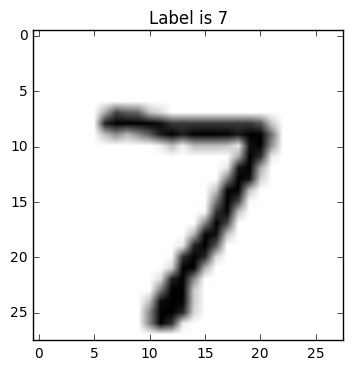

In [5]:
showImage(test_data[0], test_labels[0])